Note to Run:

- Run with same parameters
- Increase number of epochs to 50
- Re-run both u-net and clahe (inception v3)

In [1]:
import tensorflow as tf
import numpy as np
import os
from resnet50 import getResNet50
from models import getClassReport as class_report
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping, TensorBoard
import keras
from models import getConvNext, getInceptionV3, getEfficientNetB0, getROCScore

physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### U-Net Applied

In [2]:
# import pickle

# folder = '../data/augmented-data/U-Net/ODIR'

# pickle_in = open(folder + '/' + 'ODIR_AMD_w_others_pred.pickle','rb')
# ODIR_AMD_w_others = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'ODIR_Pure_AMD_pred.pickle','rb')
# ODIR_Pure_AMD = pickle.load(pickle_in)

# folder = '../data/augmented-data/U-Net/RFMID'

# pickle_in = open(folder + '/' + 'RFMID_AMD_w_others_pred.pickle','rb')
# RFMID_AMD_w_others = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMID_Pure_AMD_pred.pickle','rb')
# RFMID_Pure_AMD = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMID_normal_pred.pickle','rb')
# RFMID_normal = pickle.load(pickle_in)

# folder = '../data/augmented-data/U-Net/STARE'

# pickle_in = open(folder + '/' + 'stare_AMD_w_others_pred.pickle','rb')
# stare_AMD_w_others = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'stare_normal_pred.pickle','rb')
# stare_normal = pickle.load(pickle_in)

In [3]:
# Archived
# pickle_in = open(folder + '/' + 'ODIR_Normal_pred.pickle','rb')
# ODIR_normal = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMiD_AMD_w_others_testing_pred.pickle','rb')
# RFMID_AMD_w_others_test = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMiD_Pure_AMD_testing_pred.pickle','rb')
# RFMID_Pure_AMD_test = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMiD_normal_testing_pred.pickle','rb')
# RFMID_normal_test = pickle.load(pickle_in)

### CLAHE Applied

In [4]:
import pickle

folder = '../data/augmented-data/CLAHE/ODIR'

pickle_in = open(folder + '/' + 'ODIR_AMD_w_others_data.pickle','rb')
ODIR_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'ODIR_Pure_AMD_data.pickle','rb')
ODIR_Pure_AMD = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'ODIR_Normal_data.pickle','rb')
ODIR_normal = pickle.load(pickle_in)


folder = '../data/augmented-data/CLAHE/RFMID'

pickle_in = open(folder + '/' + 'RFMiD_AMD_w_others_data.pickle','rb')
RFMID_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMiD_Pure_AMD_data.pickle','rb')
RFMID_Pure_AMD = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMiD_normal_data.pickle','rb')
RFMID_normal = pickle.load(pickle_in)


folder = '../data/augmented-data/CLAHE/STARE'

pickle_in = open(folder + '/' + 'stare_AMD_w_others_data.pickle','rb')
stare_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'stare_normal_data.pickle','rb')
stare_normal = pickle.load(pickle_in)

In [5]:
# Get the dimensions of the image
height, width, channels = ODIR_AMD_w_others[0].shape

# Print the dimensions
print("Width:", width)
print("Height:", height)
print("Channels:", channels)

Width: 512
Height: 512
Channels: 1


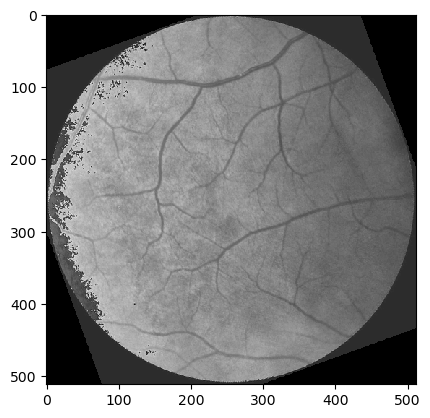

In [6]:
from matplotlib import pyplot as plt
plt.imshow(stare_normal[1], interpolation='nearest', cmap='gray')
plt.show()

In [7]:
segmented_amd_mixed = np.concatenate((ODIR_Pure_AMD[:160], RFMID_AMD_w_others), axis=0) # Complex Data
segmented_pure_amd = np.concatenate((ODIR_Pure_AMD, RFMID_Pure_AMD), axis=0) # Pure Data
segmented_amd_w_others = np.concatenate((ODIR_AMD_w_others, RFMID_AMD_w_others, stare_AMD_w_others), axis=0) # Archived Complex

segmented_complex = segmented_amd_w_others
segmented_normal = RFMID_normal[:580] # if using only clahe, put limit = [:580]

# segmented_amd_test = np.concatenate((RFMID_AMD_w_others_test, RFMID_Pure_AMD_test), axis=0)
# segmented_normal_test = RFMID_normal_test[:138]

In [8]:
print('amd:', len(segmented_complex))
print('normal:', len(segmented_normal))

amd: 560
normal: 580


In [9]:
y_amd = []
y_normal = []

for i in range(len(segmented_complex)):
    y_amd.append(1)

for i in range(len(segmented_normal)):
    y_normal.append(0)

label_amd = np.array(y_amd)
label_normal = np.array(y_normal)

In [10]:
x = np.concatenate((segmented_complex, segmented_normal), axis=0)
y = np.concatenate((label_amd, label_normal), axis=0)

In [11]:
print('x size:', len(x))
print('y size:', len(y))

x size: 1140
y size: 1140


In [12]:
from sklearn.model_selection import train_test_split

x_train, alpha, y_train, omega = train_test_split(x, y, test_size=0.2, random_state=1)
x_eval, x_test, y_eval, y_test = train_test_split(alpha, omega, test_size=0.5, random_state=1)

### Define Input Shape

In [13]:
input_shape = (512, 512, 1)

### Model Filename

In [14]:
resnet_model_filename = '../rendered-models/res-net-models/res_net_v7.h5'
resnet_clahe_model_filename = '../rendered-models/res-net-models/res_net_clahe_v1.h5'

inception_model_filename = '../rendered-models/inception-models/inception_v2.h5'
inception_clahe_model_filename = '../rendered-models/inception-models/inception_clahe_v2.h5'

cnn_model_filename = '../rendered-models/cnn-models/cnn_v2.h5'
cnn_clahe_model_filename = '../rendered-models/cnn-models/cnn_clahe_v2.h5'

### CNN Model

In [15]:
# Define the model
cnnModel = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # First fully connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### ResNet Model

In [16]:
resNetModel = getResNet50(input_shape)

### ConvNext Model

In [17]:
convNextModel = getConvNext(input_shape)

### Inception v3 Model

In [18]:
inceptionModel = getInceptionV3(input_shape)

### EFficient Net v2 Model

In [19]:
efficientNetModel = getEfficientNetB0(input_shape)
adam = keras.optimizers.Adam(lr=0.0001)

c:\Users\Randall\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Defining parameters for training

In [20]:
model = inceptionModel
model_filename = inception_model_filename

In [21]:
adam = keras.optimizers.Adam(lr=0.0001)
cnnModel.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

adam = keras.optimizers.Adam(lr=0.0001)
inceptionModel.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

adam = keras.optimizers.Adam(lr=0.0001)
resNetModel.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 255, 255, 32  288         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_40 (BatchN  (None, 255, 255, 32  96         ['conv2d_40[0][0]']              
 ormalization)                  )                                                      

In [23]:
# Define the batch size and number of epochs for training
batch_size = 32
epochs = 30
callback_checkpoint =[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False), # patience=10
ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-7, verbose=1), # patience=8
TensorBoard()]

In [24]:
print('Shapes:')
print('x_train = ', x_train.shape)
print('y_train = ', y_train.shape)
print('x_eval = ', x_eval.shape)
print('y_eval = ', y_eval.shape)

Shapes:
x_train =  (912, 512, 512, 1)
y_train =  (912,)
x_eval =  (114, 512, 512, 1)
y_eval =  (114,)


### Training

In [25]:
# with tf.device("GPU"):
#     history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_eval, y_eval),
#         callbacks=[callback_checkpoint])

In [26]:
model.evaluate(x_test, y_test, batch_size=batch_size)

4/4 [==============================] - 8s 418ms/step - loss: 0.6932 - accuracy: 0.4737


[0.6931717395782471, 0.4736842215061188]

# Testing the Model | Creating Predictions

In [27]:
model.load_weights(model_filename)
with tf.device("GPU"): 
    result = model.predict(x_test)

threshold = 0.5
predictions = np.where(result > threshold, 1, 0).flatten()
print('Predictions: ', predictions)

4/4 [==============================] - 2s 351ms/step
Predictions:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


### ROC Score

4/4 [==============================] - 1s 215ms/step


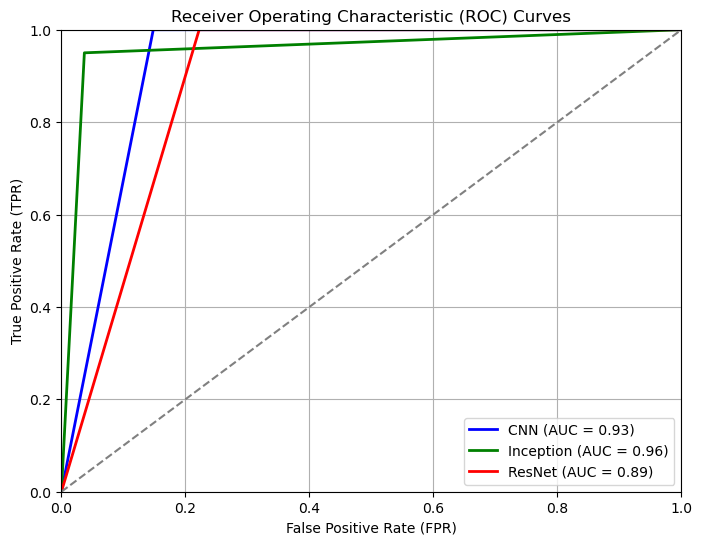

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

threshold = 0.5
# CNN
cnnModel.load_weights(cnn_clahe_model_filename)
with tf.device("GPU"): 
    result = cnnModel.predict(x_test)
result1 = np.where(result > threshold, 1, 0).flatten()
# Inception
inceptionModel.load_weights(inception_clahe_model_filename)
with tf.device("GPU"): 
    result = inceptionModel.predict(x_test)
result2 = np.where(result > threshold, 1, 0).flatten()
# ResNet
resNetModel.load_weights(resnet_clahe_model_filename)
with tf.device("GPU"): 
    result = resNetModel.predict(x_test)
result3 = np.where(result > threshold, 1, 0).flatten()

# Calculate ROC curves and AUC for each model
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test, result1)
roc_auc_model1 = auc(fpr_model1, tpr_model1)

fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_test, result2)
roc_auc_model2 = auc(fpr_model2, tpr_model2)

fpr_model3, tpr_model3, thresholds_model3 = roc_curve(y_test, result3)
roc_auc_model3 = auc(fpr_model3, tpr_model3)

# Plot the ROC curves for all three models
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='b', lw=2, label=f'CNN (AUC = {roc_auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, color='g', lw=2, label=f'Inception (AUC = {roc_auc_model2:.2f})')
plt.plot(fpr_model3, tpr_model3, color='r', lw=2, label=f'ResNet (AUC = {roc_auc_model3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Tabular View

In [29]:
import pandas as pd

data = { 'Actual': y_test, 'Predicted': predictions }
preds = pd.DataFrame(data)

preds

,Actual,Predicted
0,1,1
1,0,1
2,0,1
3,0,1
4,1,1
...,...,...
109,1,1
110,0,1
111,1,1
112,1,1


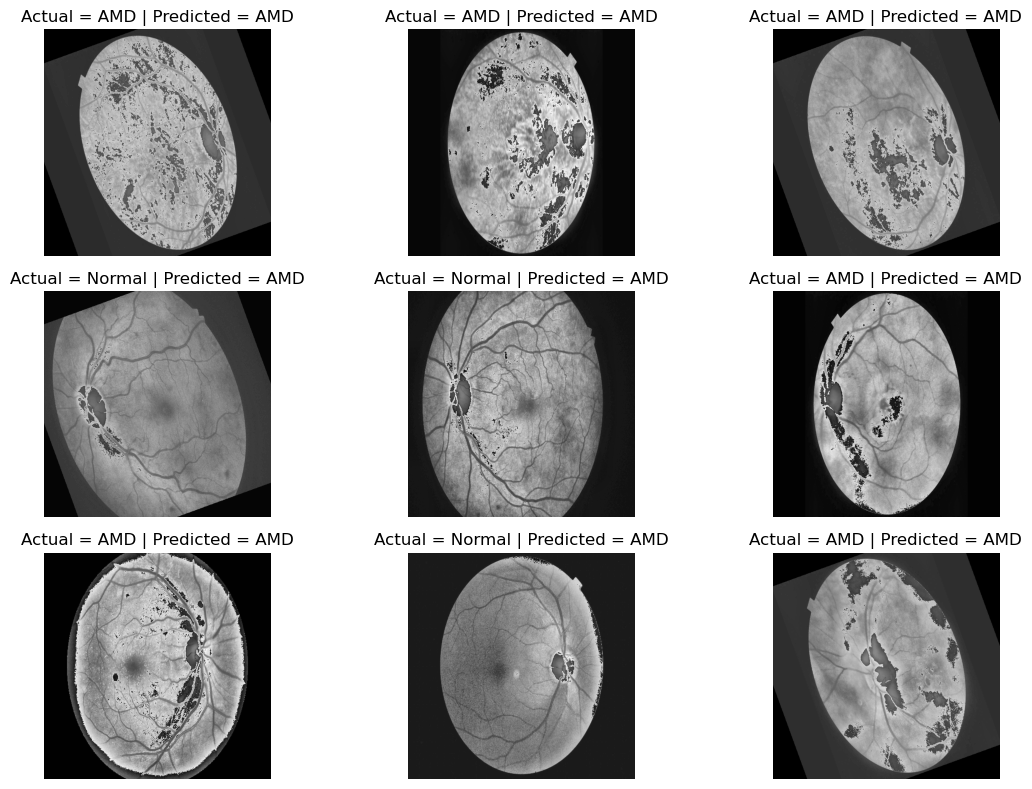

In [30]:
import matplotlib.pyplot as plt
num_rows, num_cols = 3, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()
testData = x_test[15:]

for i, (image, ax) in enumerate(zip(testData, axes)):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title('Actual = {} | Predicted = {}'.format('Normal' if y_test[i+15] == 0 else 'AMD', 'Normal' if predictions[i+15] == 0 else 'AMD'))

plt.tight_layout()
plt.show()

In [31]:
correctly_pred = (preds['Actual'] == preds['Predicted']).sum()
print(f'{correctly_pred} out of {len(preds)} were correctly predicted')
print(f'{(correctly_pred/len(preds))*100}% is your score')

60 out of 114 were correctly predicted
52.63157894736842% is your score


In [32]:
tpos = 0
tneg = 0
fpos = 0
fneg = 0

for i in range(len(preds)):
    if preds['Actual'][i] == 1 and preds['Predicted'][i] == 1:
        tpos+=1
    elif preds['Actual'][i] == 1 and preds['Predicted'][i] == 0:
        fneg+=1
    elif preds['Actual'][i] == 0 and preds['Predicted'][i] == 0:
        tneg+=1
    elif preds['Actual'][i] == 0 and preds['Predicted'][i] == 1:
        fpos+=1

In [33]:
precision = (tpos/(tpos+fpos))
recall = (tpos/(tpos+fneg))
accuracy = ((tpos+tneg)/(tpos+tneg+fpos+fneg))
fone = 2*((precision*recall)/(precision+recall))

In [34]:
print('Precision: {}%'.format(round(precision*100, 2)))
print('Recall: {}%'.format(round(recall*100, 2)))
print('Accuracy: {}%'.format(round(accuracy*100, 2)))
print('F1-Score: {}%'.format(round(fone*100, 2)))

Precision: 52.63%
Recall: 100.0%
Accuracy: 52.63%
F1-Score: 68.97%


### Confusion Matrix

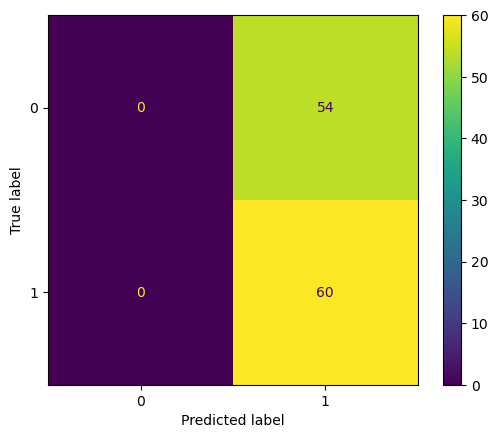

In [35]:
from models import getConfusionMatrix, getAccuracyVisual, getLossVisual
import matplotlib.pyplot as plt

getConfusionMatrix(y_test, predictions)

In [36]:
print('true positive: ', tpos)
print('false positive: ', fpos)
print('true negative: ', tneg)
print('false negative: ', fneg)

true positive:  60
false positive:  54
true negative:  0
false negative:  0


### History Vis

NameError: name 'history' is not defined

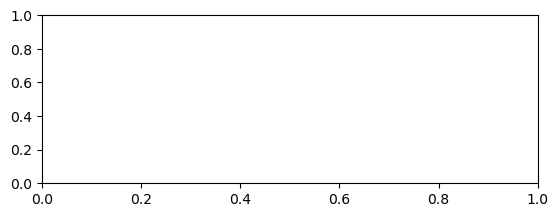

In [37]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [ ]:
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()